In [98]:
# general libraries
import pandas as pd
import pandas.testing as tm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import re
import seaborn as sns
from IPython.display import IFrame

# network analysis
import networkx as nx
from networkx.algorithms import bipartite

# text analysis
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# formatting commands
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

In [5]:
def component_size_one(G):
    '''Take a graph G and return a list of the 
       connected components of size 1 and the
       number of connected components of size 1'''
    components = [list(G) for G in nx.connected_components(G) if len(G) == 1]
    num_components = len(components)
    return components, num_components

# function to get large graph components
def giant_component_size(G):
    '''Take a graph G and return the largest connected component, 
        a list of the connected components > 1 and 
        the number of connected components > 1'''
    components = [(len(G), list(G)) for G in nx.connected_components(G) if len(G) > 1]
    num_components = len(components)
    GCC = [y[1] for y in components if y[0]
           == max([x[0] for x in components])][0]
    return GCC, components, num_components

# function to clean string
def clean_string(text):
    '''Take any text and return a cleaned version of the text
        without punctuation, lower cased, and removes stopwords'''
    text = ''.join([w for w in text if w not in string.punctuation])
    text = text.lower()
    text = ' '.join([w for w in text.split() if w not in stopwords])
    
    return text

# function to get the ngrams of a word or phrase
def ngrams(string, n=2):
    '''Takes any string removes characters, and creates
        ngrams of length n. Returns string and ngrams of
        string'''
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

# function to get the top n cosine similarity scores
def cos_sim_top(A, B, ntop, lower_bound=0):
    '''Takes any matrix A and B and returns the top n
        matching values with the higest cosine similarity
        score'''
    
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)
    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)
    return csr_matrix((data,indices,indptr),shape=(M,N))

# function to return the names that were run through the cossim_top function
def get_matches_df(sparse_matrix, name_vector, top=None):
    '''Takes any sparse matrix constructed from a name vector
        and returns the names and scores of values in the sparse
        matrix with a defned % cut off'''
    
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similarity': similairity})

In [64]:
# loading listing data
listing_url = r'https://raw.githubusercontent.com/sbiguzzi/data620/main/Assignments/FinalProject/listings_sf.csv'
listing_df = pd.read_csv(listing_url,dtype=object)
listing_df.rename(columns={'id':'listing_id'},inplace=True)
listing_df.shape

(6682, 74)

In [56]:
listing_df.head()

,listing_id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,20210407173733,2021-04-10,"Bright, Modern Garden Unit - 1BR/1BTH",Please check local laws re Covid before you re...,Quiet cul de sac in friendly neighborhood<br /...,https://a0.muscache.com/pictures/b7c2a199-4c17...,1169,https://www.airbnb.com/users/show/1169,...,10,10,10,STR-0001256,f,1,1,0,0,1.94
1,5858,https://www.airbnb.com/rooms/5858,20210407173733,2021-04-08,Creative Sanctuary,<b>The space</b><br />We live in a large Victo...,I love how our neighborhood feels quiet but is...,https://a0.muscache.com/pictures/17714/3a7aea1...,8904,https://www.airbnb.com/users/show/8904,...,10,10,9,NaN,f,1,1,0,0,0.76
2,7918,https://www.airbnb.com/rooms/7918,20210407173733,2021-04-08,A Friendly Room - UCSF/USF - San Francisco,Nice and good public transportation. 7 minute...,"Shopping old town, restaurants, McDonald, Whol...",https://a0.muscache.com/pictures/26356/8030652...,21994,https://www.airbnb.com/users/show/21994,...,9,9,8,NaN,f,8,0,8,0,0.13
3,8142,https://www.airbnb.com/rooms/8142,20210407173733,2021-04-08,Friendly Room Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,NaN,https://a0.muscache.com/pictures/27832/3b1f9e5...,21994,https://www.airbnb.com/users/show/21994,...,10,9,9,NaN,f,8,0,8,0,0.10
4,8339,https://www.airbnb.com/rooms/8339,20210407173733,2021-04-07,Historic Alamo Square Victorian,Pls email before booking. <br />Interior featu...,NaN,https://a0.muscache.com/pictures/213fbf05-3545...,24215,https://www.airbnb.com/users/show/24215,...,10,10,10,STR-0000264,f,2,2,0,0,0.20


In [77]:
# loading reviews data
# reviews_url = r'https://media.githubusercontent.com/media/sbiguzzi/data620/main/Assignments/FinalProject/reviews_sf.csv'

# reviews_df = pd.read_csv(reviews_url,dtype=object)
reviews_df = pd.read_csv("reviews_sf.csv", dtype = object)
reviews_df.shape

(279937, 6)

In [78]:
# drop null comments from review data
reviews_df.dropna(inplace=True)
reviews_df.shape

(279802, 6)

In [79]:
# drop reviews containing 'This is an automated posting'
automated = reviews_df[reviews_df.comments.str.contains('This is an automated posting')].index
reviews_df.drop(index=automated, inplace=True)
reviews_df.shape

(278464, 6)

In [74]:
# reviews_df.listing_id.sort_values(ascending = True).unique()

array(['1003174', '10037206', '10037835', ..., '9942997', '9952477',
       '998231'], dtype=object)

In [80]:
# set up dataframes to merge
df_review = reviews_df[['listing_id', 'reviewer_id', 'reviewer_name', 'id', 'date', 'comments']].copy()
df_listing = listing_df[['listing_id', 'host_id', 'host_name']].copy()

# merge the dataframes
df_merged = pd.merge(df_review, df_listing, how='left', on='listing_id')
df_merged.shape

(278464, 8)

In [61]:
df_listing.shape

(6682, 3)

In [62]:
df_listing.head()

,listing_id,host_id,host_name
0,958,1169,Holly
1,5858,8904,NaN
2,7918,21994,Aaron
3,8142,21994,Aaron
4,8339,24215,Rosy


In [81]:
df_merged[df_merged.listing_id == "5858"]

,listing_id,reviewer_id,reviewer_name,id,date,comments,host_id,host_name
276,5858,11350,Rowan,1981,2009-05-03,We had a fabulous time staying with Philip and...,8904,NaN
277,5858,11966,Annick,2993,2009-05-23,Great place to stay in SF. Tania and Philip we...,8904,NaN
278,5858,17285,Bella,3905,2009-06-12,We had an excellent stay. We loved the neighbo...,8904,NaN
279,5858,12216,Louise,5566,2009-07-15,Tania and Philip are wonderful and cheerful - ...,8904,NaN
280,5858,23106,Rachael,6800,2009-08-05,We enjoyed the great location and peaceful int...,8904,NaN
...,...,...,...,...,...,...,...,...
381,5858,29097371,Emily,30623861,2015-04-25,Tania is a good good host. She answered to al...,8904,NaN
382,5858,26927592,Danielle,43046276,2015-08-17,"This was my first experience using Airbnb, and...",8904,NaN
383,5858,30620043,Luc,46193229,2015-09-08,Our stay at Tania and Philip's place was absol...,8904,NaN
384,5858,90845099,Paulo,106889478,2016-10-08,"Gostei bastante da estadia, a Tania foi bastan...",8904,NaN


In [82]:
# clean the merged dataframe
df_merged.dropna(inplace=True)
df_merged.drop_duplicates(subset=['id'], inplace=True)
df_merged.comments = df_merged.comments.map(lambda x: x.replace('\r', ''))
df_merged.reviewer_id = df_merged.reviewer_id.astype(int)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266384 entries, 0 to 278463
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     266384 non-null  object
 1   reviewer_id    266384 non-null  int64 
 2   reviewer_name  266384 non-null  object
 3   id             266384 non-null  object
 4   date           266384 non-null  object
 5   comments       266384 non-null  object
 6   host_id        266384 non-null  object
 7   host_name      266384 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.3+ MB


In [83]:
# calculate the number of reviews per hosts
host_review_counts = df_merged.groupby('host_id')[['id']].nunique().reset_index()
host_review_counts.rename(columns={'id': 'host_review_count'}, inplace=True)

# calculate reviews per reviewer
reviewer_review_counts = df_merged.groupby('reviewer_id')[['id']].nunique().reset_index()
reviewer_review_counts.rename(columns={'id': 'reviewer_review_count'}, inplace=True)

# calculate number of listings by host
host_listing_counts = df_merged.groupby('host_id')[['listing_id']].nunique().reset_index()
host_listing_counts.rename(columns={'listing_id': 'host_listing_counts'}, inplace=True)

# calculate number of hosts reviewed by reviewers
reviewer_host_counts = df_merged.groupby(['reviewer_id'])[['host_id']].nunique().reset_index()
reviewer_host_counts.rename(columns={'host_id': 'reviewer_host_counts'}, inplace=True)

In [84]:
df_merged_final = pd.merge(df_merged, host_review_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_review_counts, how='left', on='reviewer_id')
df_merged_final = pd.merge(df_merged_final, host_listing_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_host_counts, how='left', on='reviewer_id')
df_merged_final.shape

(266384, 12)

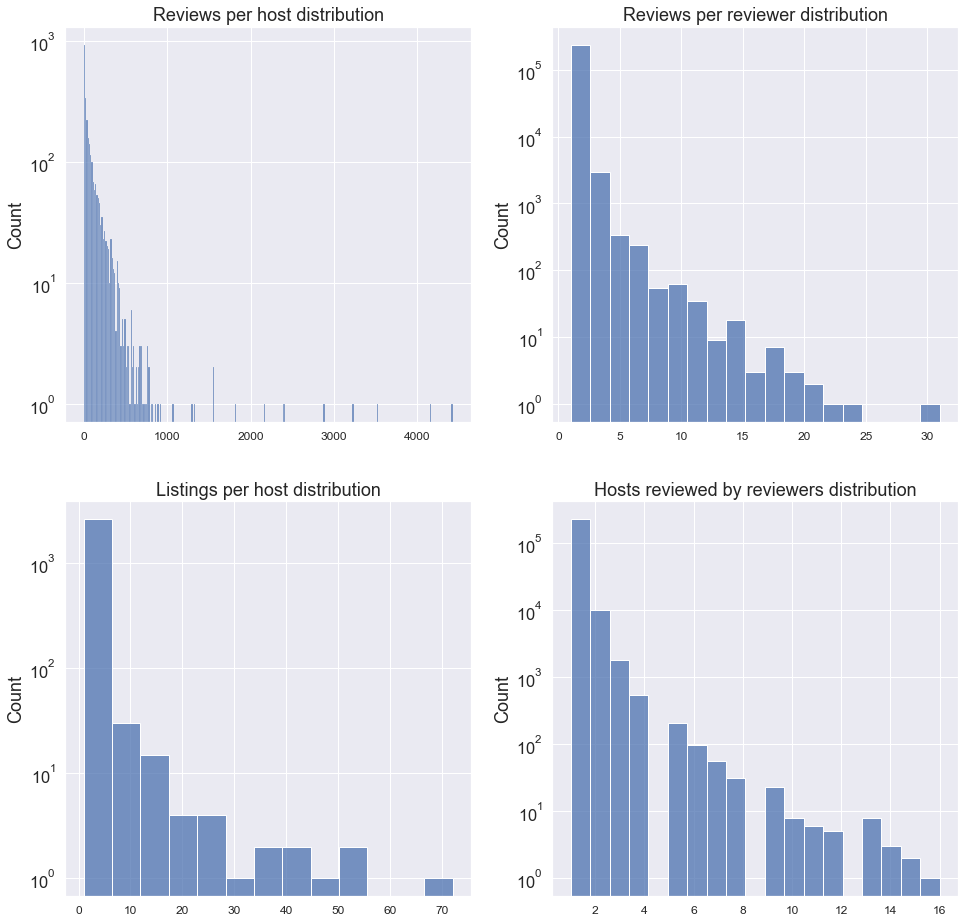

In [85]:
# plot histograms of host counts and reviewer counts
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(16, 16))
sns.histplot(host_review_counts.host_review_count, ax=ax[0,0])
sns.histplot(reviewer_review_counts.reviewer_review_count, ax=ax[0,1])
sns.histplot(host_listing_counts.host_listing_counts, ax=ax[1,0])
sns.histplot(reviewer_host_counts.reviewer_host_counts, ax=ax[1,1])
ax[0,0].set_title('Reviews per host distribution')
ax[0,1].set_title('Reviews per reviewer distribution')
ax[1,0].set_title('Listings per host distribution')
ax[1,1].set_title('Hosts reviewed by reviewers distribution')

for a in ax.flatten():
    a.set_xlabel('')
    a.tick_params(axis='x', labelsize=12, labelrotation=0)
    a.set_yscale('log')

plt.show()

In [86]:
subset = df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep=False)].copy()
subset = subset[subset.host_listing_counts >= 5]
subset = subset[subset.reviewer_host_counts > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], keep=False, inplace=True)
subset.shape

(262, 12)

In [87]:
subset = df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep = False)].copy()
subset = subset[subset.host_listing_counts >= 5]
subset = subset[subset.reviewer_host_counts > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], inplace=True)
subset.shape

(264, 12)

In [88]:
print('Number of reviewers: ', len(subset.reviewer_id.unique()))
print('Number of hosts: ', len(subset.host_id.unique()))

Number of reviewers:  89
Number of hosts:  34


In [89]:
hosts = dict(subset[['host_id', 'host_name']].values)
reviewers = dict(subset[['reviewer_id', 'reviewer_name']].values)
labels_dict = {**reviewers, **hosts}

### Initial 2-Mode Network

In [90]:
subset.reviewer_id.nunique()

89

In [91]:
subset.host_id.nunique()

34

In [92]:
G = nx.Graph()
# Use bipartite 0 or 1 to denote which node it belongs to
G.add_nodes_from(subset.reviewer_id.unique(), bipartite=0)
G.add_nodes_from(subset.host_id.unique(), bipartite=1)
G.add_edges_from(subset[['reviewer_id', 'host_id']].values)

In [93]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 123
Number of edges: 99
Average degree:   1.6098


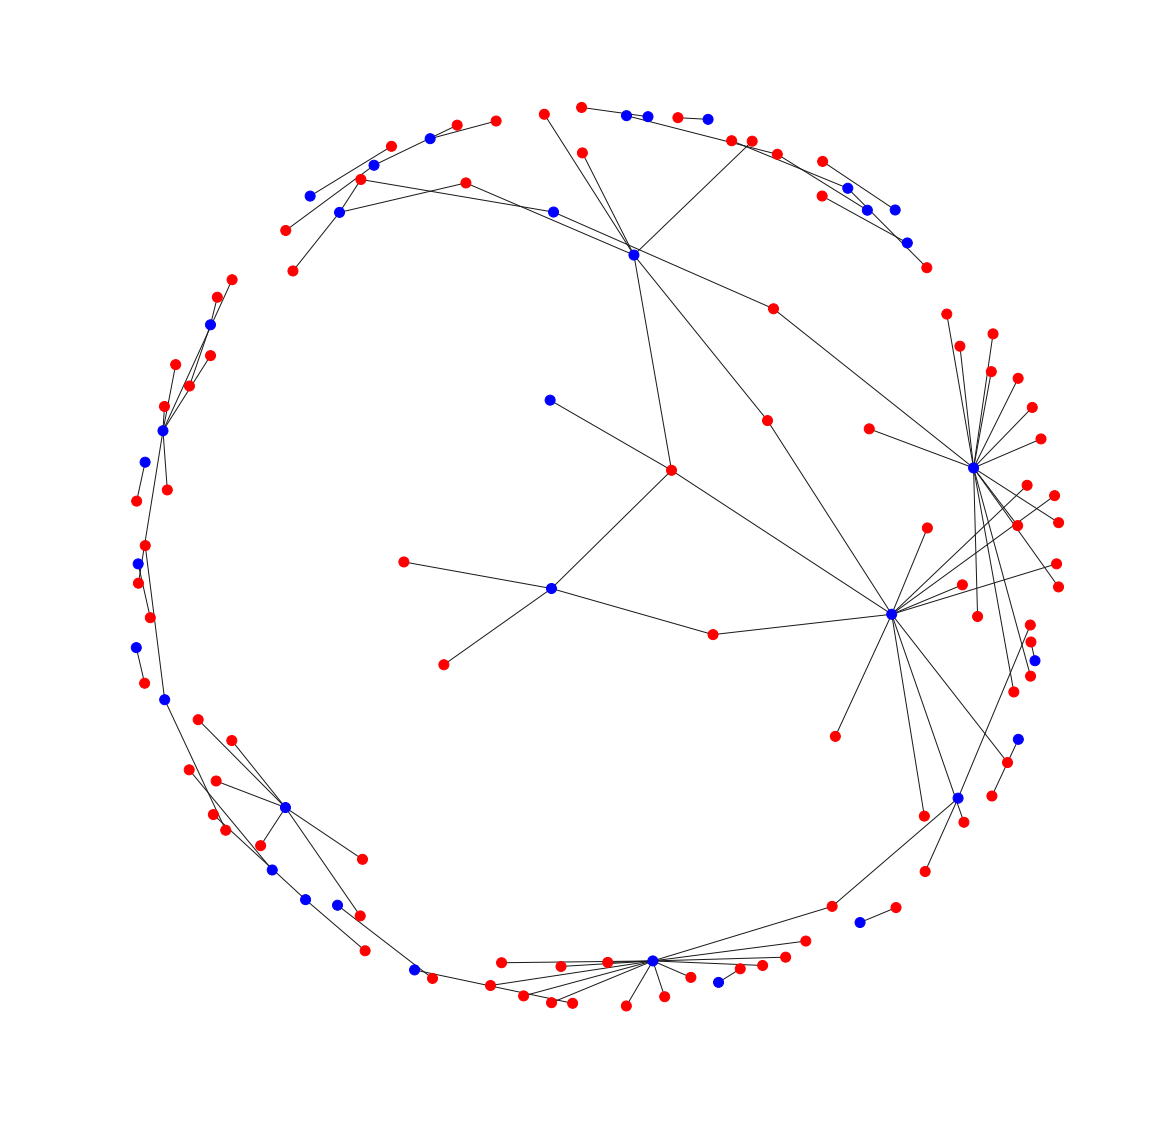

In [94]:
# nodes
reviewer_nodes = subset.reviewer_id.unique().tolist()
host_nodes = subset.host_id.unique().tolist()

# create plot
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G,iterations=35)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)))
nx.draw_networkx_edges(G, pos, width=1)
plt.axis("off")
plt.show()

### Bipartite host graph

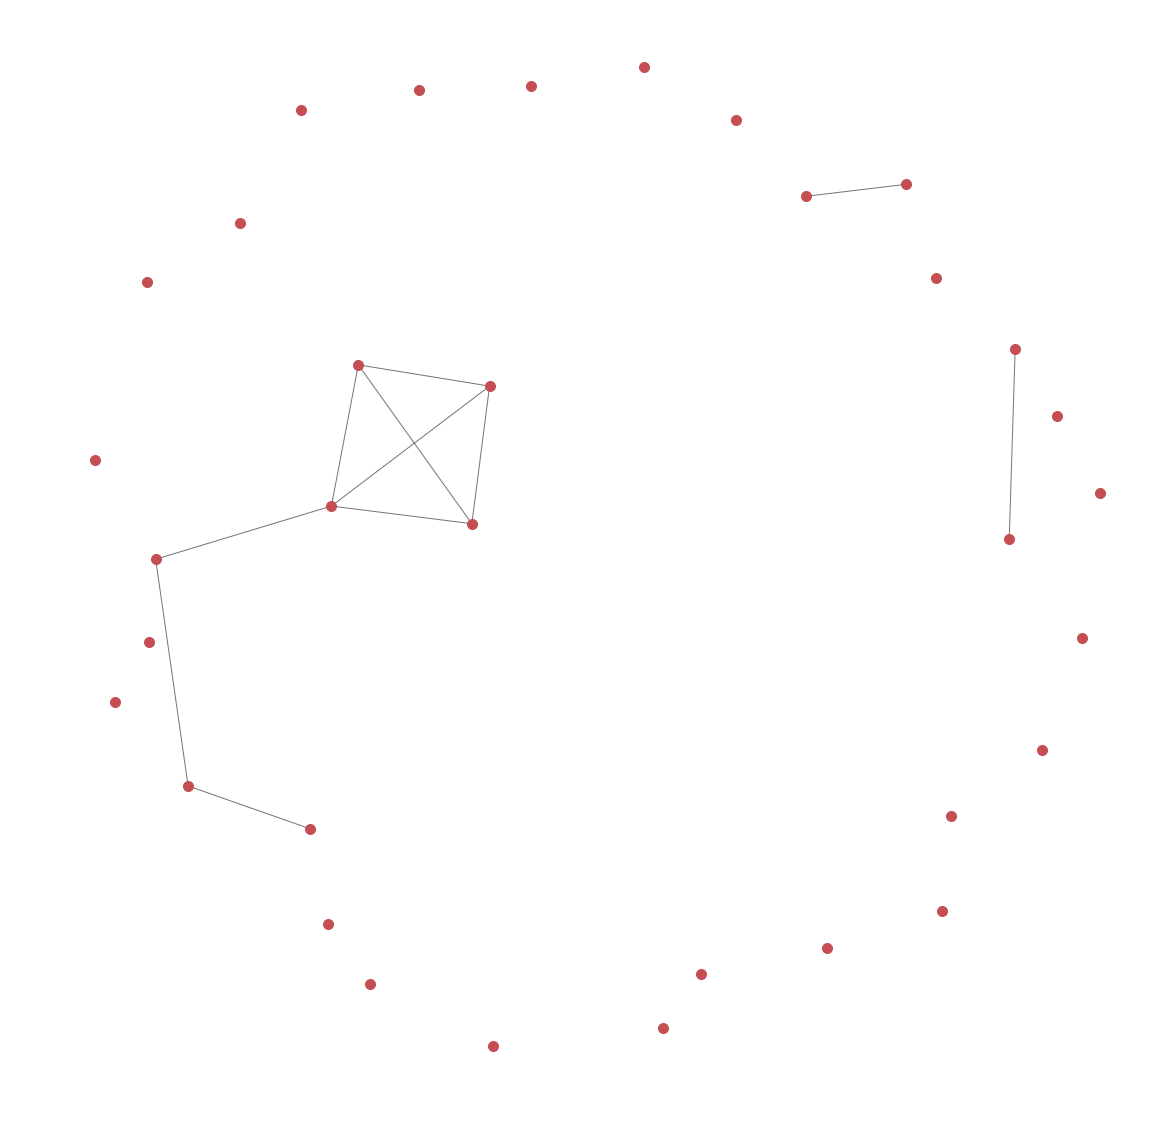

In [95]:
# look at projected graph (on hosts)
host_nodes = subset.host_id.unique().tolist()
B = bipartite.projected_graph(G, host_nodes)

pos = nx.spring_layout(B,iterations=15)
labels = {node: labels_dict[node] for node in B.nodes()}

# create plot
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(B, pos, node_size=100)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.6)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=10, font_family="sans-serif")
plt.axis("off")
plt.show()

In [96]:
# identify the components with no links
components_one, n_one = component_size_one(B)
components_one = [item for sublist in components_one for item in sublist]

print("Number of components:\n", n_one)

Number of components:
 23


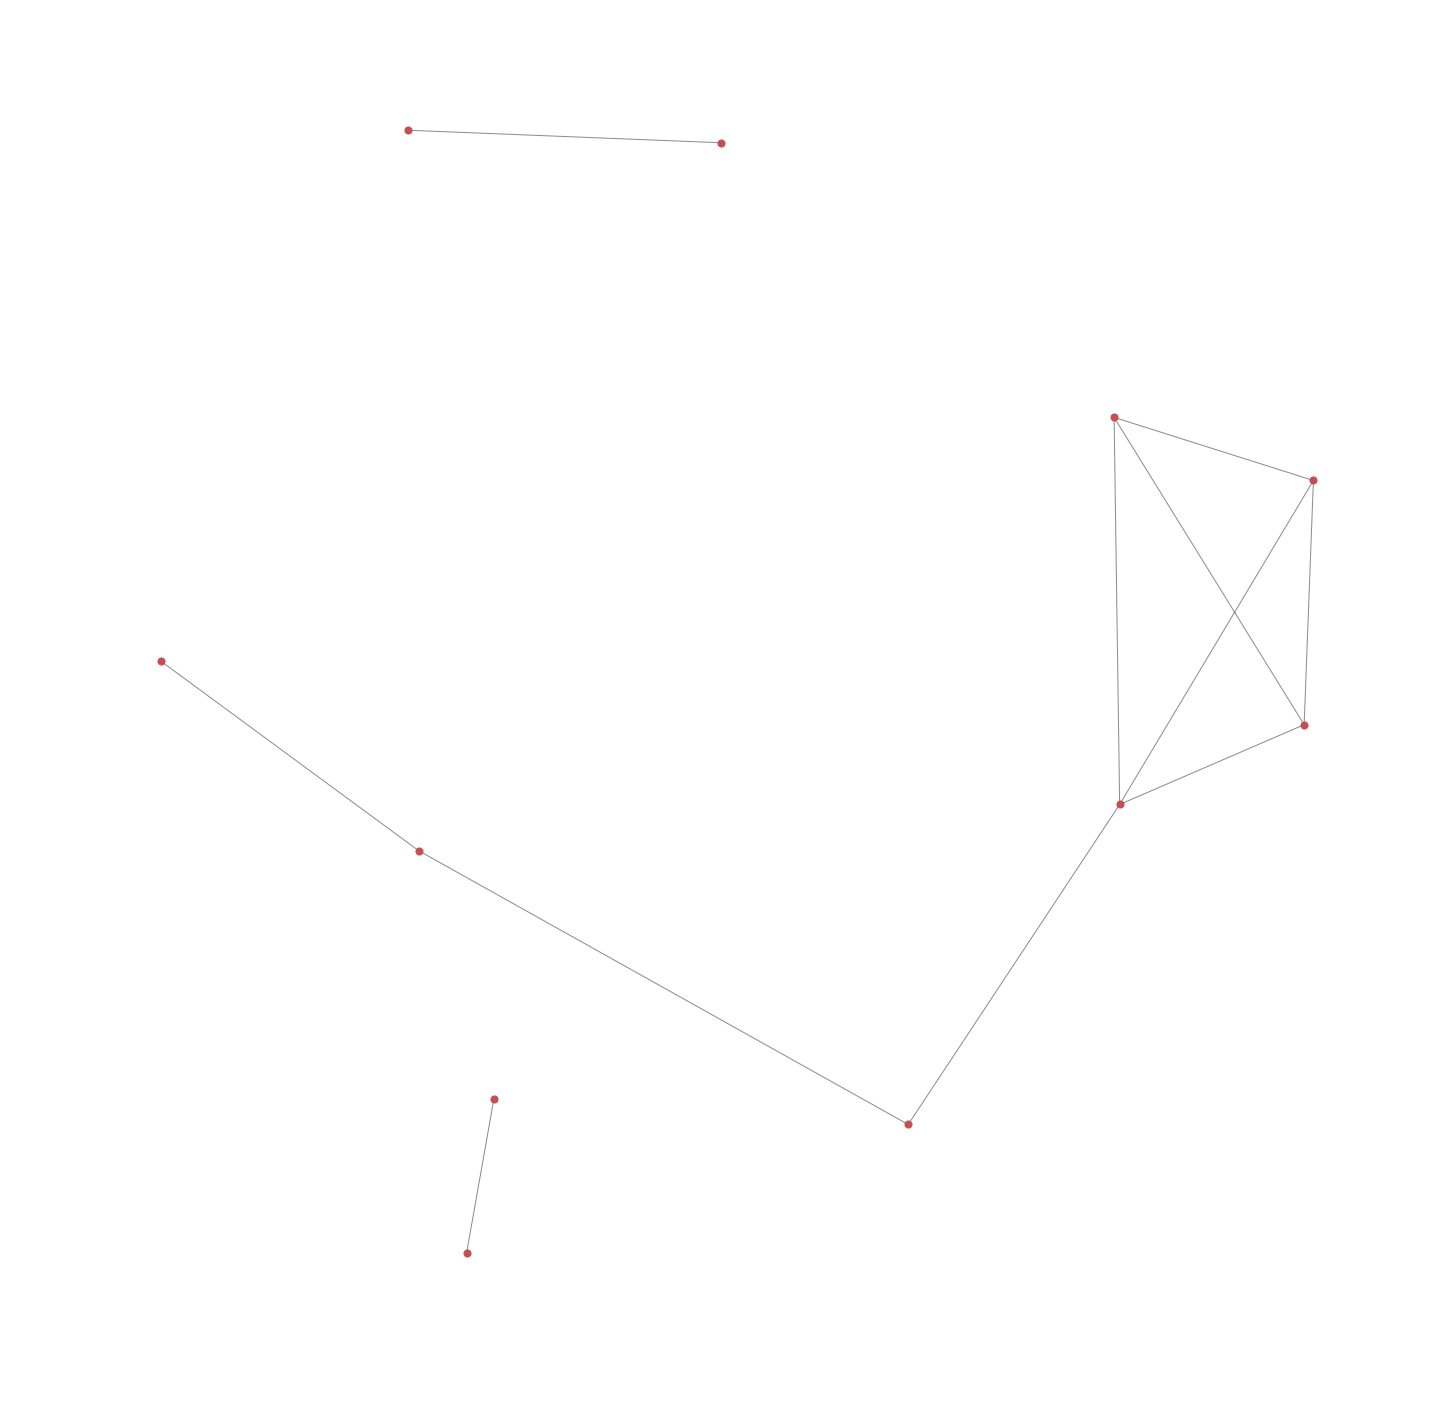

In [97]:
# remove the hosts with no links and plot the remaining ones
B.remove_nodes_from(components_one)

pos = nx.spring_layout(B,iterations=16)
labels = {node: labels_dict[node] for node in B.nodes()}

plt.figure(figsize=(25,25))
# nx.draw_networkx(B, pos, with_labels=False, node_size=100)
nx.draw_networkx_nodes(B, pos, node_size=50)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.5)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=12, font_family="sans-serif")
plt.axis("off")
plt.show()